<a href="https://colab.research.google.com/github/arpitaanigam/disease-detection-model/blob/main/PlantDiseaseDetecteionModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.69G/2.70G [00:22<00:00, 125MB/s]
100% 2.70G/2.70G [00:22<00:00, 130MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/new-plant-diseases-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import cv2 as cv
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model, layers, Sequential, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model



In [ ]:
train_dir='/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dir='/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir='/content/test/test'

In [ ]:
Size=224
X_test=[]
y_test=[]

In [ ]:
import tensorflow as tf
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1/255.0,
).flow_from_directory(train_dir,batch_size=16,target_size=(Size,Size),subset="training",shuffle=True)

Found 70295 images belonging to 38 classes.


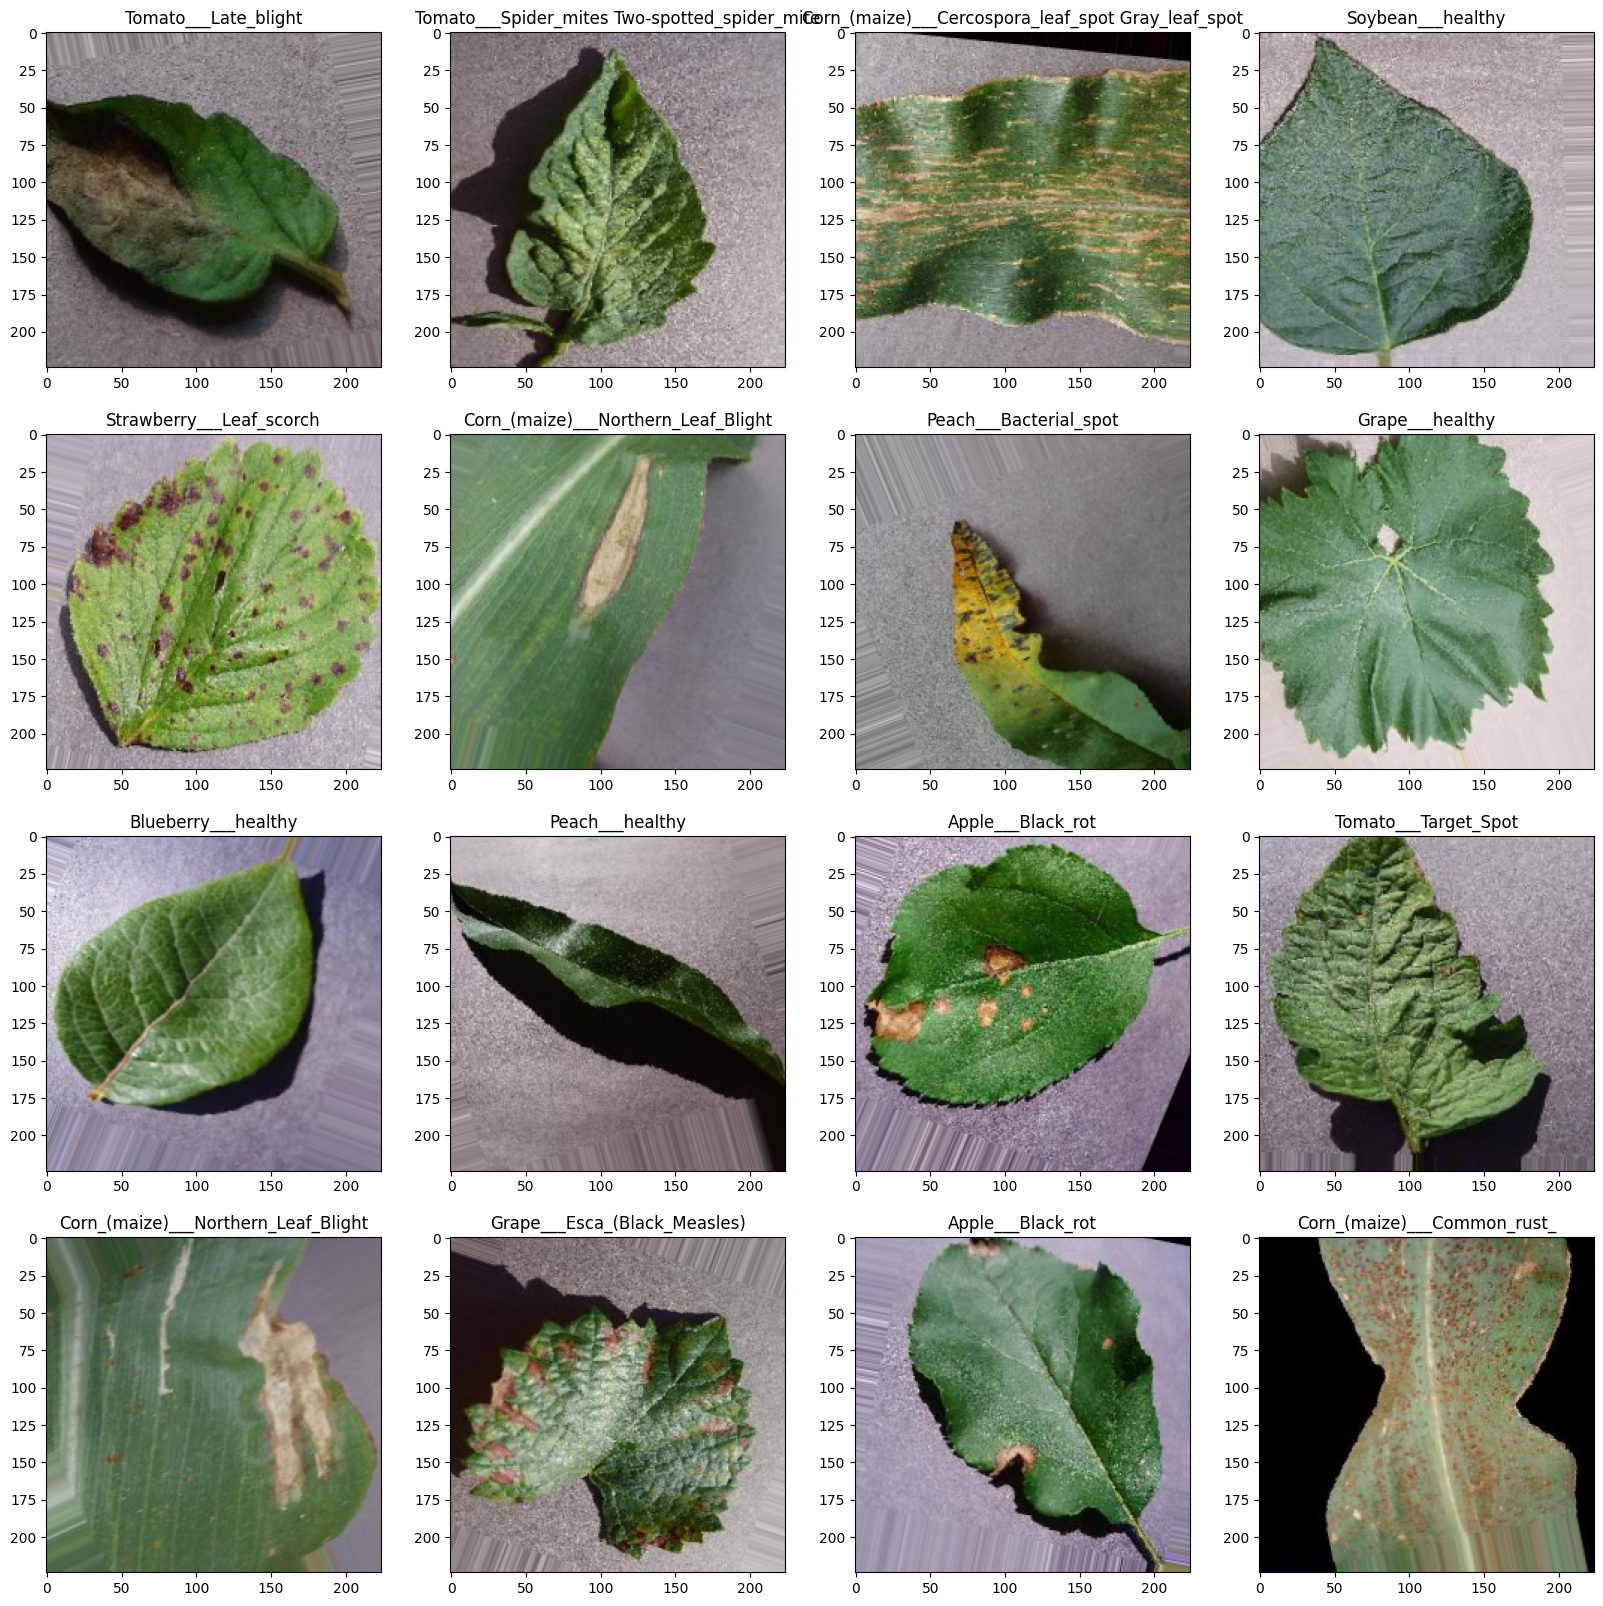

In [ ]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:

    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [ ]:
print(classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [ ]:


valid_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
).flow_from_directory(valid_dir,batch_size=16,target_size=(Size,Size),shuffle=False)



Found 17572 images belonging to 38 classes.


In [ ]:
X_test=[]
for folder in os.listdir(test_dir):
    files=gb.glob(test_dir+'/*.JPG')
    for file in files :
        img=cv.imread(file)
        X_test.append(cv.resize(img,(Size,Size)))

In [ ]:
X_test=np.array(X_test)
print(X_test.shape)

(1089, 224, 224, 3)


In [ ]:
X_test=X_test/255.0

In [ ]:
import keras
from keras.layers import Flatten , Dense , Dropout , BatchNormalization , MaxPooling2D ,Conv2D
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint



In [ ]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]


Inception model

In [ ]:
inception_model = InceptionV3(input_shape= (Size, Size, 3),
                                include_top = False,
                                weights = "imagenet")



for layer in inception_model.layers:
    layer.trainable = False


# Taking output from 'mixed8' layer
last_layer = inception_model.get_layer('mixed9')
print('Last Layer Output Shape:', last_layer.output_shape)
last_output = last_layer.output


x = layers.Flatten()(last_output)

x = layers.Dense(2048, activation='relu')(x)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense(38, activation='softmax')(x)

inception3 = Model(inception_model.input, x)

87910968/87910968 [==============================] - 0s 0us/step
Last Layer Output Shape: (None, 5, 5, 2048)


In [ ]:
inception3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=inception3.fit(train_generator,validation_data=valid_generator,epochs=100,batch_size=32,
                  steps_per_epoch=len(train_generator)//16,validation_steps=len(valid_generator)//16,
                  callbacks=callback, verbose=1)

Epoch 1/100
274/274 [==============================] - ETA: 0s - loss: 1.5739 - accuracy: 0.5878
Epoch 1: val_loss improved from inf to 0.54211, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


274/274 [==============================] - 85s 269ms/step - loss: 1.5739 - accuracy: 0.5878 - val_loss: 0.5421 - val_accuracy: 0.8180 - lr: 0.0010
Epoch 2/100
274/274 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.7810
Epoch 2: val_loss improved from 0.54211 to 0.33392, saving model to model.hdf5
274/274 [==============================] - 74s 271ms/step - loss: 0.6872 - accuracy: 0.7810 - val_loss: 0.3339 - val_accuracy: 0.9035 - lr: 0.0010
Epoch 3/100
274/274 [==============================] - ETA: 0s - loss: 0.6045 - accuracy: 0.8287
Epoch 3: val_loss did not improve from 0.33392
274/274 [==============================] - 66s 242ms/step - loss: 0.6045 - accuracy: 0.8287 - val_loss: 0.4740 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 4/100
274/274 [==============================] - ETA: 0s - loss: 0.5165 - accuracy: 0.8403
Epoch 4: val_loss improved from 0.33392 to 0.20341, saving model to model.hdf5
274/274 [==============================] - 81s 295ms/step - los

In [ ]:


ModelLoss, ModelAccuracy = inception3.evaluate(valid_generator)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy))



1099/1099 [==============================] - 47s 43ms/step - loss: 0.2669 - accuracy: 0.9159
Test Loss is 0.2669488787651062
Test Accuracy is 0.9158889055252075


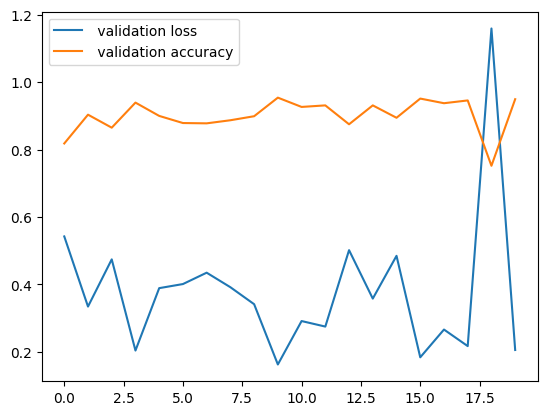

In [ ]:
plt.plot(history.history['val_loss'],label=' validation loss')
plt.plot(history.history['val_accuracy'],label=' validation accuracy')
plt.legend()

In [ ]:
inceptionv3_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy'])-1]


AlexNet architecture

In [ ]:



alexnet=Sequential([
                Conv2D(96,11,activation='relu',strides=4,input_shape=(Size,Size,3)),
                BatchNormalization(),
                MaxPooling2D(3,strides=2),


                Conv2D(256,5,activation='relu',strides=1),
                MaxPooling2D(3,strides=2),

                Conv2D(384,3,activation='relu',strides=1),
                Conv2D(384,3,activation='relu',strides=1),
                Conv2D(256,3,activation='relu',strides=1),
                MaxPooling2D(3,strides=2),
                Flatten(),
                Dense(4096,activation='relu'),
                Dense(4096,activation='relu'),
                Dense(38,activation='softmax')
])



In [ ]:
alexnet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=alexnet.fit(train_generator,validation_data=valid_generator,epochs=100,batch_size=32,
                  steps_per_epoch=len(train_generator)//16,validation_steps=len(valid_generator)//16,
                  callbacks=callback, verbose=1)

Epoch 1/100
274/274 [==============================] - ETA: 0s - loss: 3.5950 - accuracy: 0.0436
Epoch 1: val_loss did not improve from 0.16204
274/274 [==============================] - 64s 207ms/step - loss: 3.5950 - accuracy: 0.0436 - val_loss: 3.6035 - val_accuracy: 9.1912e-04 - lr: 0.0010
Epoch 2/100
274/274 [==============================] - ETA: 0s - loss: 3.4334 - accuracy: 0.0764
Epoch 2: val_loss did not improve from 0.16204
274/274 [==============================] - 59s 216ms/step - loss: 3.4334 - accuracy: 0.0764 - val_loss: 4.1079 - val_accuracy: 0.0267 - lr: 0.0010
Epoch 3/100
274/274 [==============================] - ETA: 0s - loss: 3.2772 - accuracy: 0.1056
Epoch 3: val_loss did not improve from 0.16204
274/274 [==============================] - 59s 213ms/step - loss: 3.2772 - accuracy: 0.1056 - val_loss: 3.3984 - val_accuracy: 0.0018 - lr: 0.0010
Epoch 4/100
274/274 [==============================] - ETA: 0s - loss: 3.1262 - accuracy: 0.1298
Epoch 4: val_loss did not 

In [ ]:
ModelLoss, ModelAccuracy = alexnet.evaluate(valid_generator)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

1099/1099 [==============================] - 33s 30ms/step - loss: 2.4306 - accuracy: 0.2887
Test Loss is 2.430604934692383
Test Accuracy is 0.2886979281902313


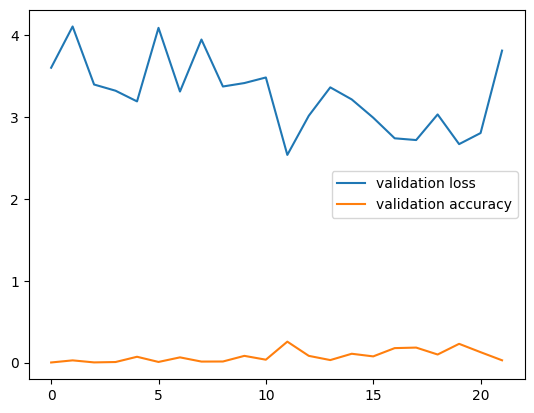

In [ ]:


plt.plot(history.history['val_loss'],label='validation loss')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend()



In [ ]:


alexnet_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy'])-1]



In [ ]:


models = ["inceptionv3","alexnet"]
Models = [inception3,alexnet]

accuracies = [inceptionv3_accuracy,alexnet_accuracy]

best_model_index = accuracies.index(max(accuracies))
print("best performing model :",models[best_model_index])
best_model_name = models[best_model_index]
best_model = Models[best_model_index]



best performing model : inceptionv3



metrics applied on best model

In [ ]:
predictions=best_model.predict(valid_generator)

1099/1099 [==============================] - 45s 39ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_generator.classes, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       504
           1       0.97      0.96      0.97       497
           2       0.90      0.96      0.93       440
           3       0.96      0.85      0.91       502
           4       0.95      0.98      0.97       454
           5       0.96      0.98      0.97       421
           6       1.00      0.93      0.96       456
           7       0.91      0.89      0.90       410
           8       0.97      1.00      0.98       477
           9       0.91      0.90      0.90       477
          10       1.00      1.00      1.00       465
          11       0.96      0.94      0.95       472
          12       0.92      0.96      0.94       480
          13       1.00      0.96      0.98       430
          14       0.99      0.95      0.97       423
          15       0.97      1.00      0.98       503
          16       1.00      0.89      0.94       459
          17       0.95    

<Axes: >

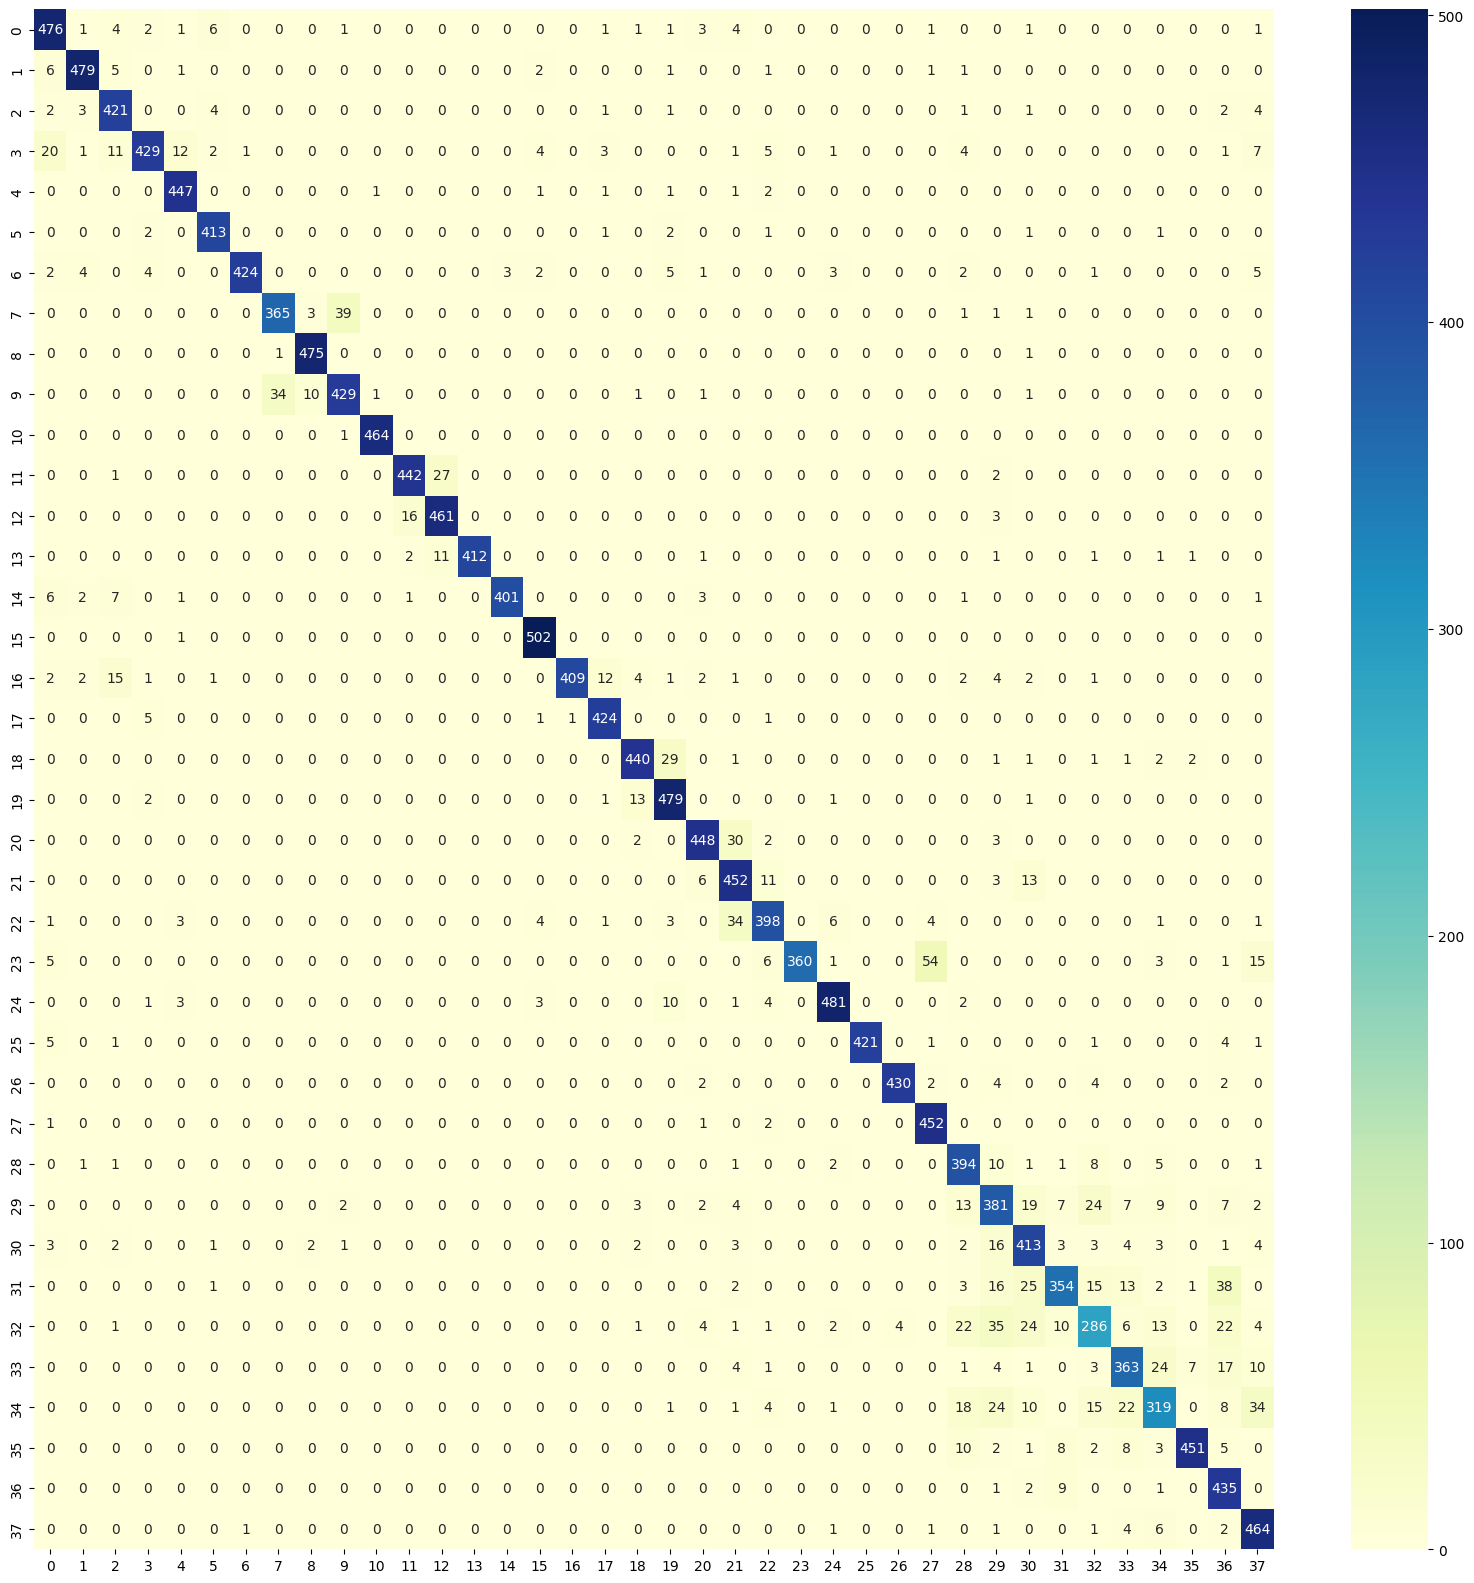

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_generator.classes, predictions.argmax(axis=1))
plt.figure(figsize=(20,20))
sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")


Inference on new examples

In [ ]:


y_pred=best_model.predict(X_test)



35/35 [==============================] - 8s 111ms/step


In [ ]:


y_pred[0]



array([1.2981017e-04, 1.4308756e-04, 5.9367076e-04, 2.1470676e-05,
       2.8396486e-05, 2.9775385e-05, 1.3385443e-06, 2.9482751e-04,
       1.1308502e-05, 9.2507427e-05, 5.5751461e-06, 6.3436315e-04,
       1.7463138e-04, 2.1334301e-04, 6.7347937e-06, 8.3149716e-06,
       6.4905401e-04, 1.1264875e-05, 2.6628829e-03, 1.1115373e-04,
       4.8855722e-02, 3.3843219e-02, 2.5418893e-04, 3.5947978e-05,
       4.6940456e-04, 8.5415493e-05, 8.9708017e-04, 4.5395460e-05,
       7.7150539e-02, 7.2746533e-01, 7.5974022e-03, 2.0724891e-03,
       8.3226822e-02, 3.1316205e-04, 1.1434016e-02, 2.0209835e-04,
       3.1813292e-05, 1.9637929e-04], dtype=float32)

In [ ]:
predictions=y_pred.argmax(axis=1)

In [ ]:


classes



['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [ ]:


predictions



array([29,  8, 34, ..., 21, 29,  2])

In [ ]:
predictions[0]

29

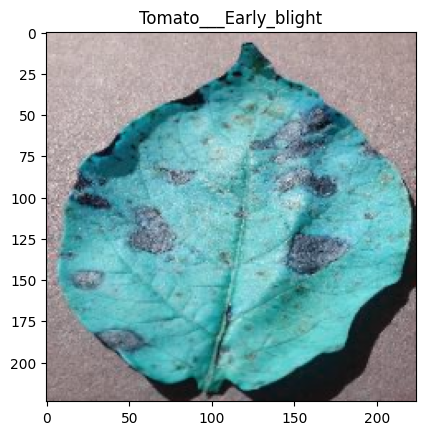

In [ ]:


plt.imshow(X_test[0])
plt.title(classes[predictions[0]])
plt.show()

